# Detecting Pneumonia in Chest X-Rays

# Installing the libraries:

In [1]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
#!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

5.3.0


In [2]:
!unzip chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
   creating: chest_xray/test/
   creating: chest_xray/test/NORMAL/
  inflating: chest_xray/test/NORMAL/IM-0001-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0003-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0005-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0006-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0007-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0009-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0010-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0011-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0013-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0015-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0016-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0017-0001.jpeg  
  inflating: chest_xray/test/NORMAL/IM-0019-0001.jpeg  
  inflating: chest_xray/test/NORM

# Importing the modules:

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
data_dir = '/chest_xray'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
import torch
import numpy as np
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data Augmentation:

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


class_names= image_datasets['train'].classes

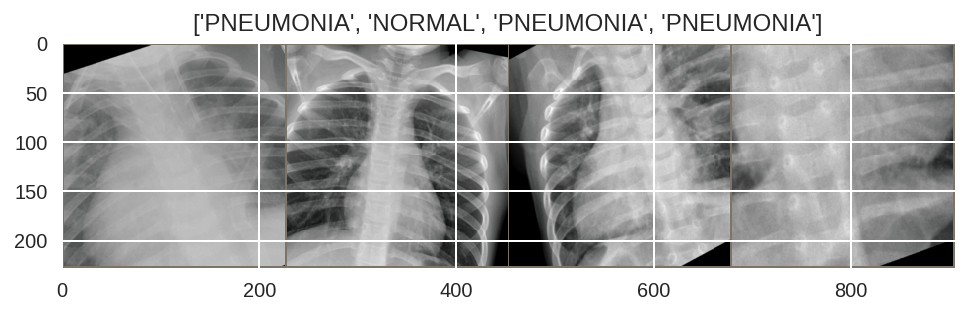

In [96]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])

# Installing Pre-trained model: Resnet-152

In [8]:
# Build and train your network
# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:14<00:00, 17183548.78it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Network Architecture:

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))



# Replacing the pretrained model classifier with our classifier
model.fc = classifier

# Training the model:

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [89]:
#Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

 #Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Using GPU: True
Epoch 1/20
----------
train Loss: 0.2746 Acc: 0.8832
test Loss: 0.2744 Acc: 0.8926

Epoch 2/20
----------
train Loss: 0.2797 Acc: 0.8813
test Loss: 0.2824 Acc: 0.8990

Epoch 3/20
----------
train Loss: 0.2734 Acc: 0.8859
test Loss: 0.2953 Acc: 0.8942

Epoch 4/20
----------
train Loss: 0.2616 Acc: 0.8913
test Loss: 0.3201 Acc: 0.8894

Epoch 5/20
----------
train Loss: 0.2702 Acc: 0.8827
test Loss: 0.3032 Acc: 0.8974

Epoch 6/20
----------
train Loss: 0.2662 Acc: 0.8869
test Loss: 0.3514 Acc: 0.8862

Epoch 7/20
----------
train Loss: 0.2682 Acc: 0.8832
test Loss: 0.2776 Acc: 0.8862

Epoch 8/20
----------
train Loss: 0.2551 Acc: 0.8917
test Loss: 0.3526 Acc: 0.8702

Epoch 9/20
----------
train Loss: 0.2566 Acc: 0.8924
test Loss: 0.3358 Acc: 0.8862

Epoch 10/20
----------
train Loss: 0.2553 Acc: 0.8917
test Loss: 0.3105 Acc: 0.8942

Epoch 11/20
----------
train Loss: 0.2403 Acc: 0.8951
test Loss: 0.3632 Acc: 0.8766

Epoch 12/20
----------
train Loss: 0.2371 Acc: 0.8976
test

# Validation:

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

In [91]:
test(model, dataloaders, device)

Testing Accuracy: 0.006
Testing Accuracy: 0.013
Testing Accuracy: 0.018
Testing Accuracy: 0.024
Testing Accuracy: 0.027
Testing Accuracy: 0.034
Testing Accuracy: 0.040
Testing Accuracy: 0.046
Testing Accuracy: 0.050
Testing Accuracy: 0.054
Testing Accuracy: 0.061
Testing Accuracy: 0.067
Testing Accuracy: 0.074
Testing Accuracy: 0.080
Testing Accuracy: 0.087
Testing Accuracy: 0.093
Testing Accuracy: 0.099
Testing Accuracy: 0.104
Testing Accuracy: 0.109
Testing Accuracy: 0.115
Testing Accuracy: 0.120
Testing Accuracy: 0.127
Testing Accuracy: 0.131
Testing Accuracy: 0.136
Testing Accuracy: 0.143
Testing Accuracy: 0.149
Testing Accuracy: 0.154
Testing Accuracy: 0.160
Testing Accuracy: 0.165
Testing Accuracy: 0.171
Testing Accuracy: 0.178
Testing Accuracy: 0.184
Testing Accuracy: 0.191
Testing Accuracy: 0.197
Testing Accuracy: 0.204
Testing Accuracy: 0.210
Testing Accuracy: 0.216
Testing Accuracy: 0.223
Testing Accuracy: 0.228
Testing Accuracy: 0.232
Testing Accuracy: 0.237
Testing Accuracy

In [0]:
# Save the checkpoint 


model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [2, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size':2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '90_checkpoint.pth')

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('90_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

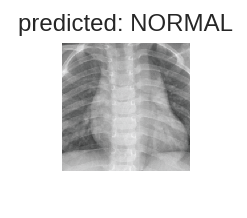

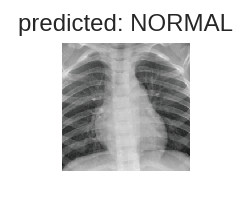

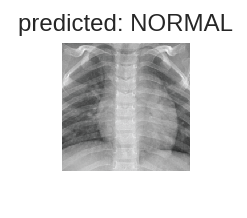

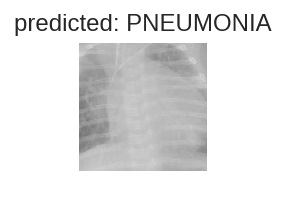

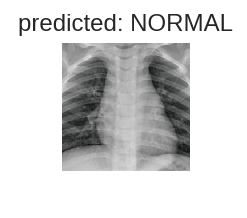

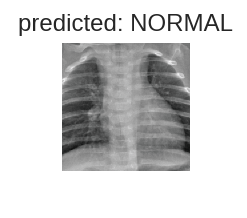

In [100]:
visualize_model(model_ft)

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((0, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Predictions:

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path).convert('RGB'))])
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_probability, top_class

In [104]:
print (predict('chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', loaded_model))

(array([0.7030984 , 0.29690155], dtype=float32), ['PNEUMONIA', 'NORMAL'])


In [0]:
# Display an image along with the top  classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = 'Prediction'
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10),  ncols=1, nrows=2)
    ct_name = img_filename
    
    ax1.set_title(ct_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities, color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(x for x in classes)
    ax2.invert_yaxis()

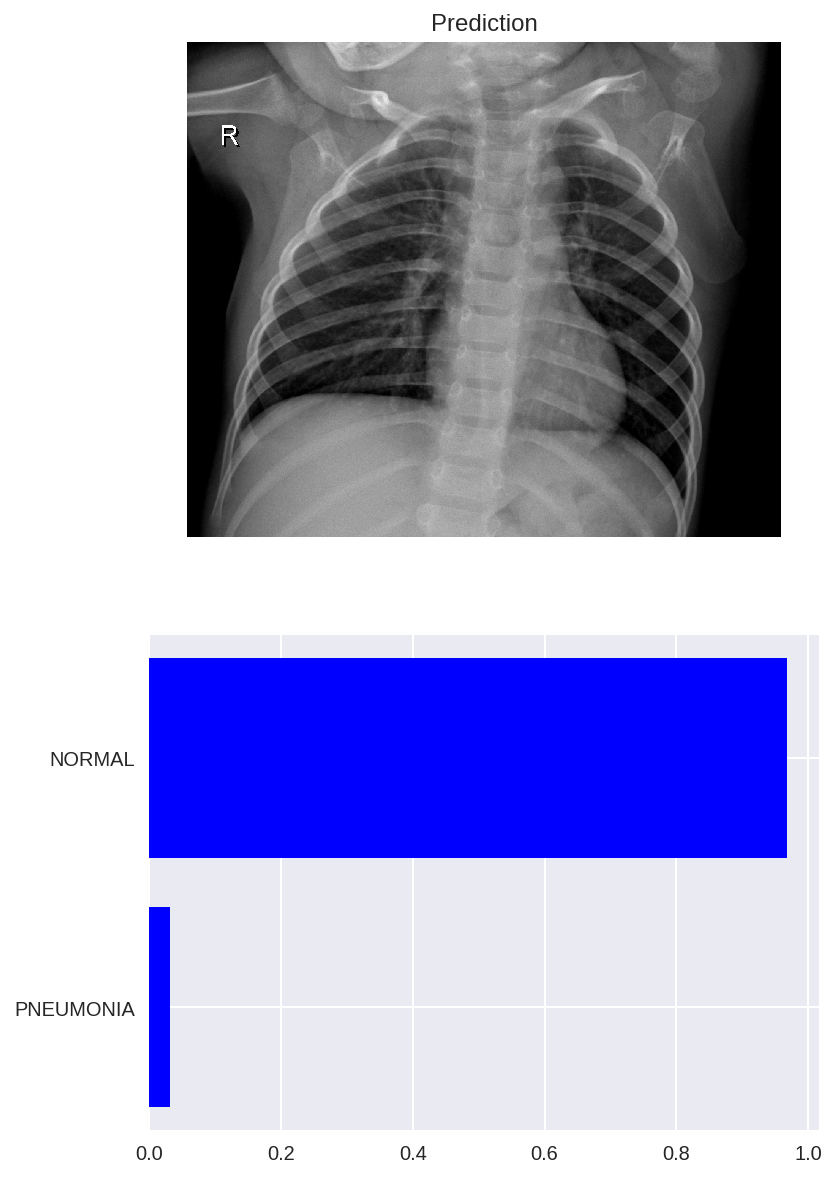

In [109]:
img = 'chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

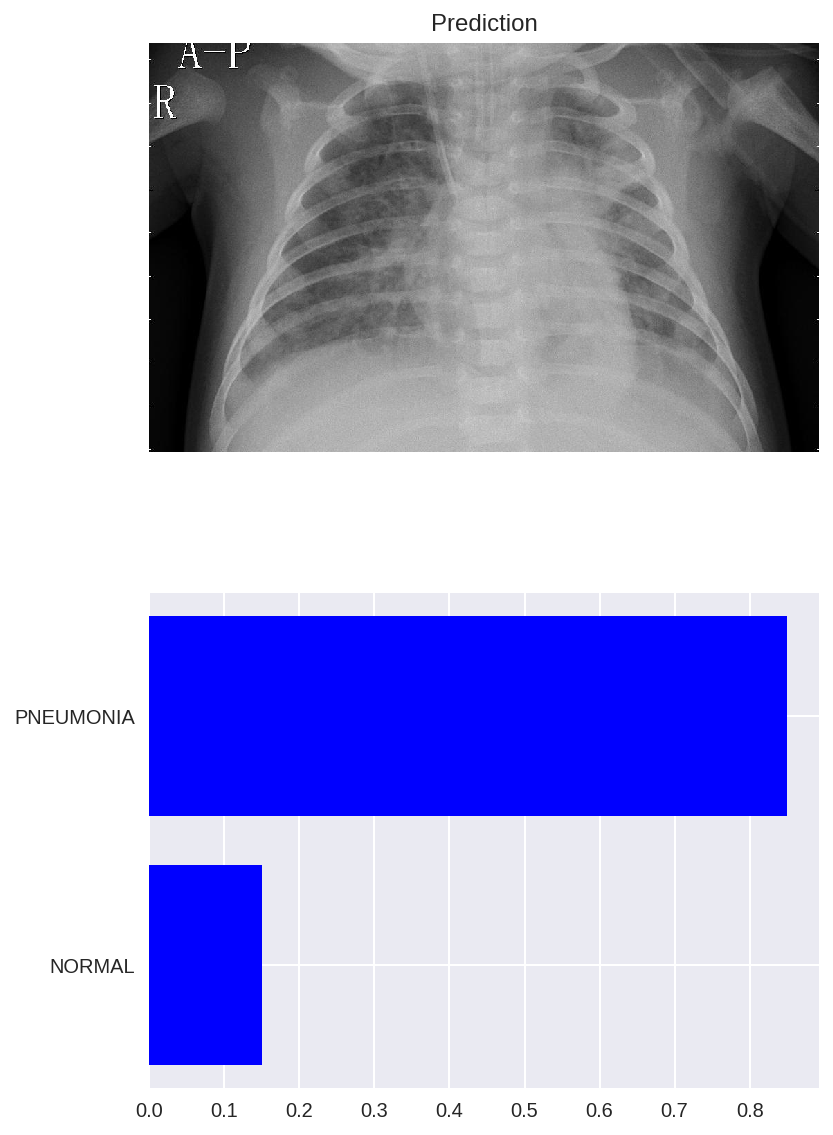

In [111]:
img = 'chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

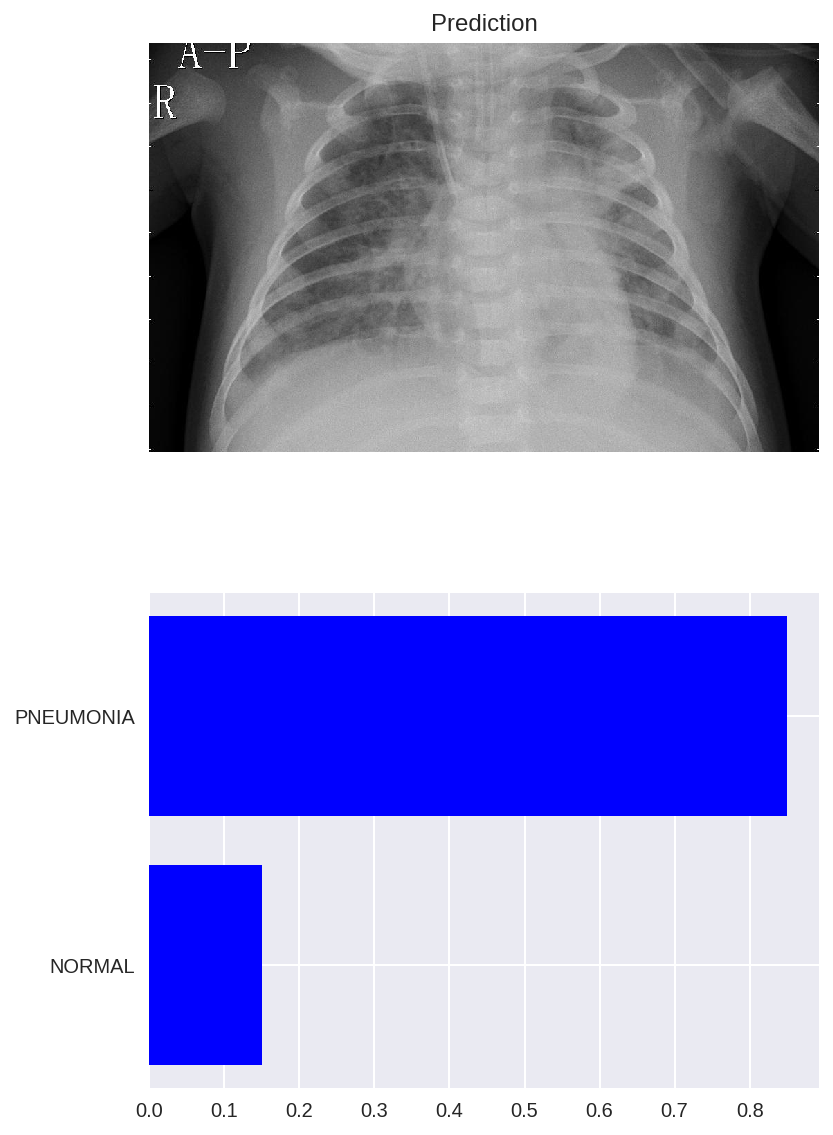

In [112]:
img = 'chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

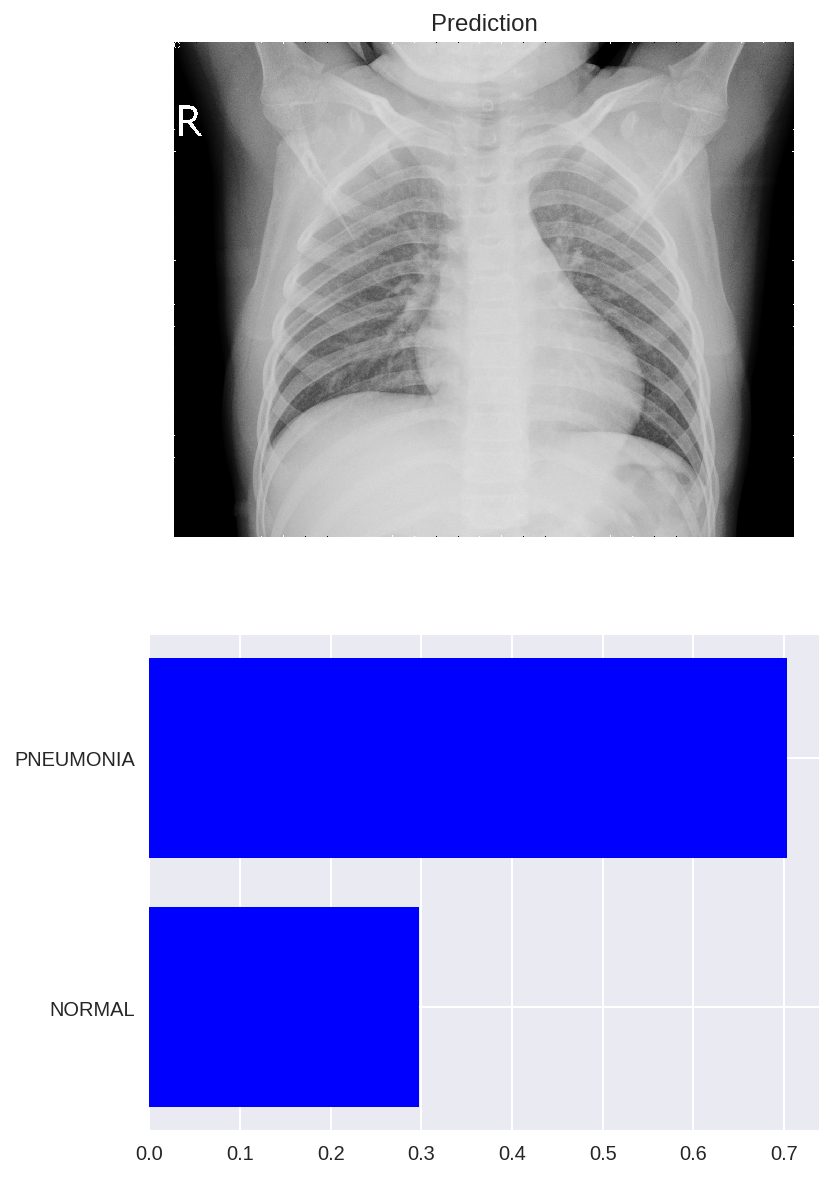

In [113]:
img = 'chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

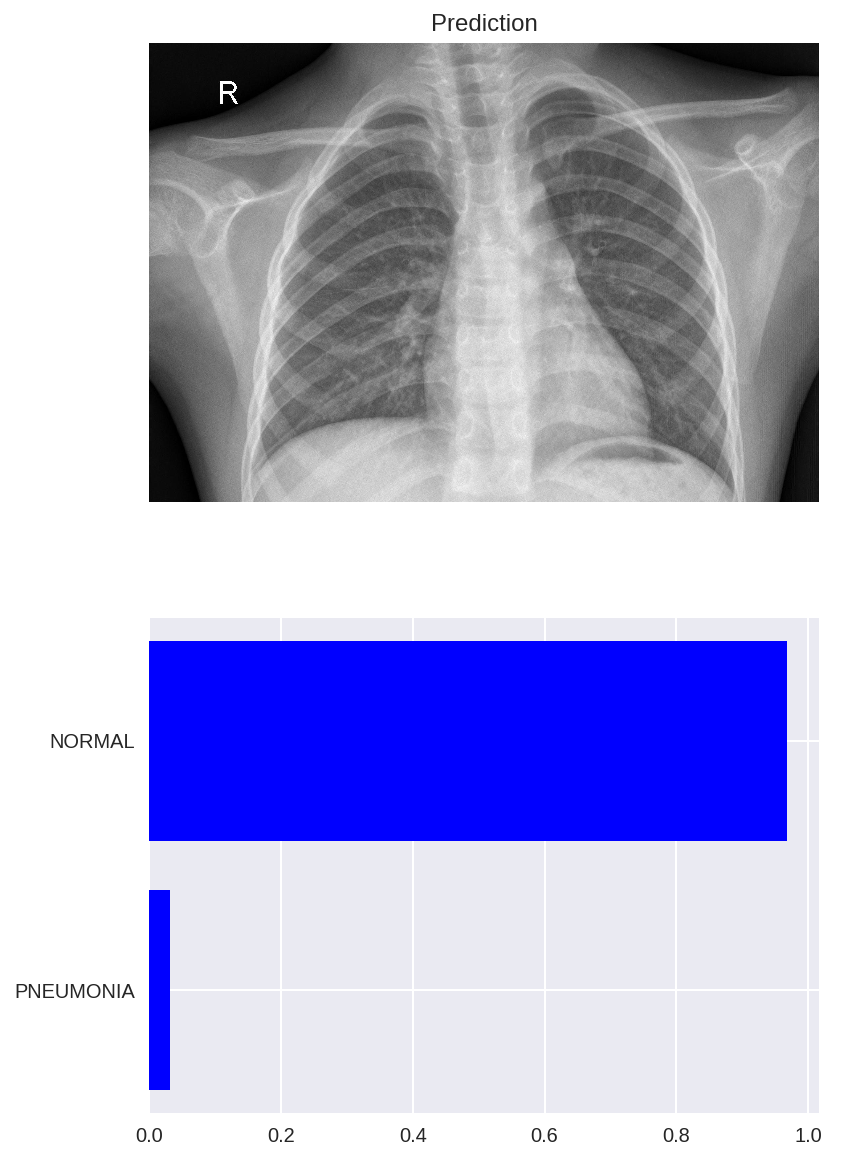

In [114]:
img = 'chest_xray/test/NORMAL/IM-0023-0001.jpeg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)